##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Tuning Quickstart with Python

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this notebook, you'll learn how to get started with model tuning.

## What is model tuning?

Prompt design strategies such as few shot prompting may not always produce the results you need. Use model tuning to improve a model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want.

The goal of model tuning is to further improve the performance of the model for your specific task. Model tuning works by providing the model with a training dataset containing many examples of the task. For niche tasks, you can get significant improvements in model performance by tuning the model on a modest number of examples.

Your training data should be structured as examples with prompt inputs and expected response outputs. The goal is to teach the model to mimic the wanted behavior or task, by giving it many examples illustrating that behavior or task.

You can also tune models using example data directly in Google AI Studio.

## OAuth Authentication

Unlike the other quickstarts which use API keys, model tuning uses OAuth.

This tutorial assumes you have completed the [OAuth Quickstart](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication_with_OAuth.ipynb) and you have your client secret saved as `CLIENT_SECRET` in the Colab secrets manager.

> Important: **Don't just click the link this command prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back
here.

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.12
albumentations                   1.4.12
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.7.29.0.32.7
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                 

In [ ]:
from google.colab import userdata
import pathlib
pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

In [ ]:
# Use `--no-browser` in colab
!gcloud auth application-default login --no-browser --client-id-file /env/client_secret2.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai

You can check your existing tuned models with the `genai.list_tuned_model` method.

In [ ]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

**Note**: In general, you need between 100 and 500 examples to significantly change the behavior of the model.

In [ ]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      top_p=1.0,
      top_k=1)

In [ ]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=[
        {
             'text_input': '1',
             'output': '2',
        },{
             'text_input': '3',
             'output': '4',
        },{
             'text_input': '-3',
             'output': '-2',
        },{
             'text_input': 'twenty two',
             'output': 'twenty three',
        },{
             'text_input': 'two hundred',
             'output': 'two hundred one',
        },{
             'text_input': 'ninety nine',
             'output': 'one hundred',
        },{
             'text_input': '8',
             'output': '9',
        },{
             'text_input': '-98',
             'output': '-97',
        },{
             'text_input': '1,000',
             'output': '1,001',
        },{
             'text_input': '10,100,000',
             'output': '10,100,001',
        },{
             'text_input': 'thirteen',
             'output': 'fourteen',
        },{
             'text_input': 'eighty',
             'output': 'eighty one',
        },{
             'text_input': 'one',
             'output': 'two',
        },{
             'text_input': 'three',
             'output': 'four',
        },{
             'text_input': 'seven',
             'output': 'eight',
        }
    ],
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-5392',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='',
           description='',
           temperature=0.9,
           top_p=1.0,
           top_k=1,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 3, 16, 0, 41, 42, 702621, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 3, 16, 0, 41, 42, 702621, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 3, 16, 0, 41, 43, 81144, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  learning_rate=0.001)

In [ ]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.metadata

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://generativeai.devsite.corp.google.com/guide/model_tuning_guidance#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

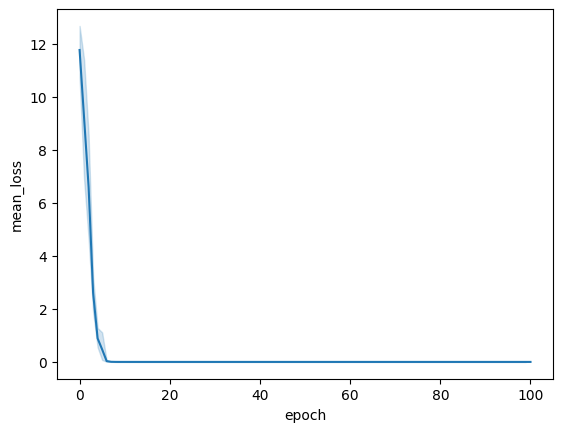

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_text` method and specify the name of your model to test your model performance.

In [ ]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [ ]:
result = model.generate_content('55')
result.text

'56'

In [ ]:
result = model.generate_content('123455')
result.text

'123456'

In [ ]:
result = model.generate_content('four')
result.text

'five'

In [ ]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'cinq'

In [ ]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'IV'

In [ ]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/docs/model_tuning_guidance) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")